In [1]:
import pathlib

import tqdm

import pandas as pd

from openff.evaluator.client.client import RequestResult
from openff.evaluator.datasets.datasets import PhysicalPropertyDataSet
from openff.toolkit import Molecule, ForceField
import seaborn as sns

from matplotlib import pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
directory = pathlib.Path("optimize.tmp")

In [3]:
ff_files = sorted(directory.glob("phys-prop/iter*/force-field.offxml"))

In [7]:
reference = ForceField("forcefield/force-field.offxml", allow_cosmetic_attributes=True)
ref_vdw_handler = reference.get_parameter_handler("vdW")

In [9]:
rmin_data = {}
epsilon_data = {}
for prop in ref_vdw_handler.parameters:
    if not hasattr(prop, "_parameterize"):
        continue
    rmin_data[prop.id] = [prop.rmin_half.m]
    epsilon_data[prop.id] = [prop.epsilon.m]

for ff_file in tqdm.tqdm(ff_files):
    ff = ForceField(ff_file, allow_cosmetic_attributes=True)
    vdw_handler = ff.get_parameter_handler("vdW")
    for param in vdw_handler.parameters:
        if not hasattr(param, "_parameterize"):
            continue
        rmin_data[param.id].append(param.rmin_half.m)
        epsilon_data[param.id].append(param.epsilon.m)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  2.81it/s]


In [16]:
iter_cols = [f"iter_{n}" for n in range(len(ff_files))]

rmin_df = pd.DataFrame.from_dict(
    rmin_data,
    orient="index",
    columns=["Reference"] + iter_cols
).reset_index(
    names=["Parameter"]
).melt(
    id_vars=["Parameter", "Reference"],
    value_vars=iter_cols,
    var_name="Iteration",
    value_name="Value",
)
rmin_df["Iteration"] = [int(x.split("_")[-1]) for x in rmin_df.Iteration.values]
rmin_df

,Parameter,Reference,Iteration,Value
0,n2,1.484200,0,1.484200
1,n3,1.449786,0,1.449786
2,n4,1.287000,0,1.287000
3,n7,1.443813,0,1.443813
4,n8,1.377051,0,1.377051
...,...,...,...,...
123,n18,1.697784,7,1.674978
124,n19,1.682099,7,1.669309
125,n20,1.799798,7,1.795842
126,n24,1.856287,7,1.829792


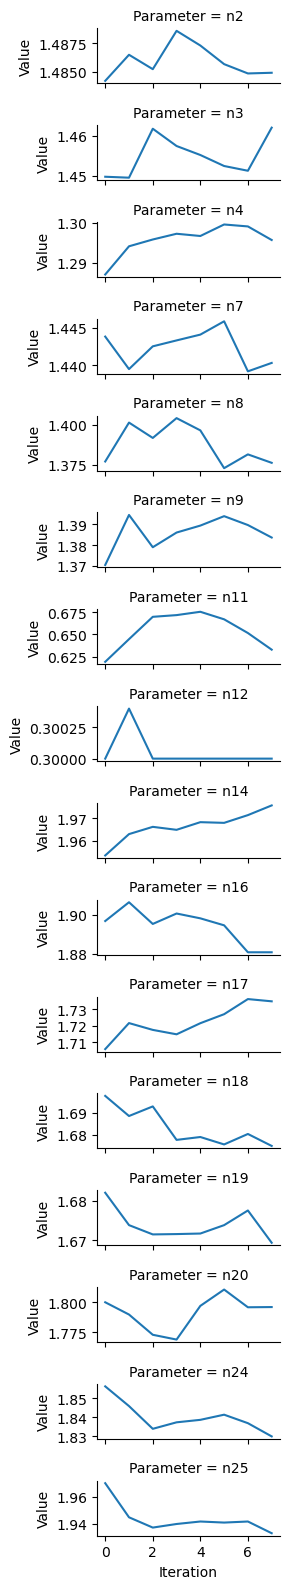

In [23]:
g = sns.FacetGrid(
    data=rmin_df,
    row="Parameter",
    aspect=3,
    height=1,
    sharey=False,
)
g.map(sns.lineplot, "Iteration", "Value")
g.savefig("rmin_half.png", dpi=300)

In [21]:
iter_cols = [f"iter_{n}" for n in range(len(ff_files))]

epsilon_df = pd.DataFrame.from_dict(
    epsilon_data,
    orient="index",
    columns=["Reference"] + iter_cols
).reset_index(
    names=["Parameter"]
).melt(
    id_vars=["Parameter", "Reference"],
    value_vars=iter_cols,
    var_name="Iteration",
    value_name="Value",
)
epsilon_df["Iteration"] = [int(x.split("_")[-1]) for x in epsilon_df.Iteration.values]
epsilon_df

,Parameter,Reference,Iteration,Value
0,n2,0.015779,0,0.015779
1,n3,0.016409,0,0.016409
2,n4,0.015700,0,0.015700
3,n7,0.015611,0,0.015611
4,n8,0.013107,0,0.013107
...,...,...,...,...
123,n18,0.168465,7,0.167233
124,n19,0.209474,7,0.207852
125,n20,0.167692,7,0.166220
126,n24,0.265600,7,0.265822


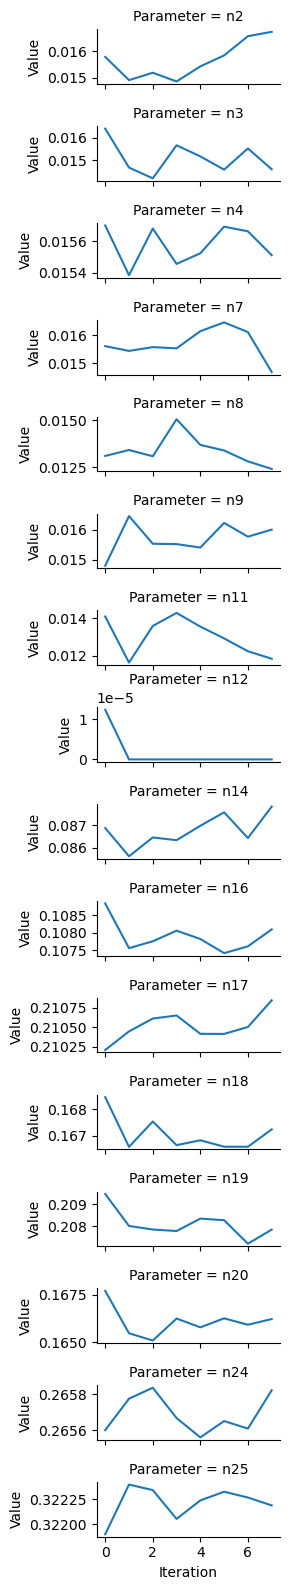

In [24]:
g = sns.FacetGrid(
    data=epsilon_df,
    row="Parameter",
    aspect=3,
    height=1,
    sharey=False,
)
g.map(sns.lineplot, "Iteration", "Value")
g.savefig("epsilon.png", dpi=300)